# UniGuard Wallet — Model Selection Notebook

This notebook compares **multiple algorithms for each AI model** using the
cleaned datasets saved in this `notebooks/` folder. It does **NOT** write
artifacts back to the frontend; it is only for experimentation.

Cleaned datasets expected here (created by the per-model training notebooks):

- `transaction_categorizer_clean.csv`
- `spending_forecaster_clean.csv`
- `budget_allocator_clean.csv`
- `goal_predictor_clean.csv`
- `anomaly_detector_clean.csv`

Before running this notebook:

1. In each `train_*.ipynb` notebook, run:
   - Download datasets
   - Export cleaned datasets
   - **Save cleaned dataset next to this notebook** (cell `2b`)
2. Install the Python dependencies in your environment:

```bash
source .venv/bin/activate  # if you use .venv
pip install pandas numpy scikit-learn matplotlib
```

Then run the cells below to compare algorithms for each task.


In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, IsolationForest

# In Jupyter, __file__ is not defined; use current working directory
NOTEBOOK_DIR = Path.cwd()
print("Notebook dir:", NOTEBOOK_DIR)

MODELS_DIR = NOTEBOOK_DIR / "trained_models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print("Models will be saved under:", MODELS_DIR)


Notebook dir: /home/mukama/Desktop/finance 2 (Copy)/notebooks
Models will be saved under: /home/mukama/Desktop/finance 2 (Copy)/notebooks/trained_models


## 1. Transaction Categorizer — algorithm comparison

Goal: predict `category` from `description`, `amount`, maybe `type`.

We will compare:

- Logistic Regression
- Random Forest
- Gradient Boosting


In [28]:
tx_path = NOTEBOOK_DIR / "transaction_categorizer_clean.csv"
if not tx_path.exists():
    raise FileNotFoundError(f"Missing {tx_path}. Run the transaction_categorizer notebook first.")

tx = pd.read_csv(tx_path)
print(tx.shape)
tx.head()


(2237, 5)


,date,description,amount,category,type
0,2018-01-10,Phone Company,89.46,Communication,debit
1,2018-01-25,Internet Service Provider,69.99,Communication,debit
2,2018-02-12,Phone Company,89.52,Communication,debit
3,2018-02-26,Internet Service Provider,74.99,Communication,debit
4,2018-03-12,Phone Company,89.52,Communication,debit


/home/mukama/Desktop/finance 2 (Copy)/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg macro_f1= 0.9925327270221855 weighted_f1= 0.9910680758971634
RF macro_f1= 1.0 weighted_f1= 1.0
GB macro_f1= 1.0 weighted_f1= 1.0


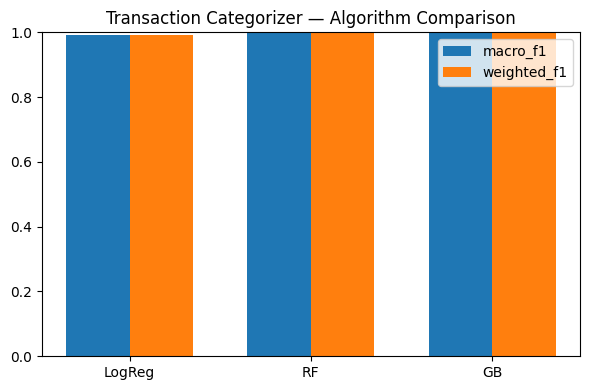

In [29]:
X = tx[["description", "amount", "type"]].copy()
y = tx["category"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

text_features = ["description"]
num_features = ["amount"]
cat_features = ["type"]

preprocess = ColumnTransformer(
    transformers=[
        ("text", OneHotEncoder(handle_unknown="ignore", max_categories=500), text_features),
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

models = {
    "LogReg": LogisticRegression(max_iter=200, n_jobs=-1),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GB": GradientBoostingClassifier(random_state=42),
}

tx_results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    macro = f1_score(y_test, preds, average="macro")
    weighted = f1_score(y_test, preds, average="weighted")
    tx_results[name] = {"macro_f1": macro, "weighted_f1": weighted}
    print(name, "macro_f1=", macro, "weighted_f1=", weighted)

plt.figure(figsize=(6, 4))
labels = list(tx_results.keys())
macro_vals = [tx_results[k]["macro_f1"] for k in labels]
weighted_vals = [tx_results[k]["weighted_f1"] for k in labels]
x = np.arange(len(labels))
w = 0.35
plt.bar(x - w/2, macro_vals, width=w, label="macro_f1")
plt.bar(x + w/2, weighted_vals, width=w, label="weighted_f1")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Transaction Categorizer — Algorithm Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# Save best transaction categorizer model (Random Forest)

best_tx_model = Pipeline(steps=[("prep", preprocess), ("clf", models["RF"])])
best_tx_model.fit(X, y)
model_path = MODELS_DIR / "transaction_categorizer_rf.joblib"
joblib.dump(best_tx_model, model_path)
print("Saved transaction categorizer RF model to:", model_path)

Saved transaction categorizer RF model to: /home/mukama/Desktop/finance 2 (Copy)/notebooks/trained_models/transaction_categorizer_rf.joblib


## 2. Spending Forecaster — algorithm comparison

Goal: predict **monthly spending amount** per category.

We will compare:

- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor


In [9]:
sp_path = NOTEBOOK_DIR / "spending_forecaster_clean.csv"
if not sp_path.exists():
    raise FileNotFoundError(f"Missing {sp_path}. Run the spending_forecaster notebook first.")

sp = pd.read_csv(sp_path)
print(sp.shape)
sp.head()


(6814, 3)


,date,category,amount
0,2022-07-06 05:57:10+00:00,Eating Out,5.50
1,2022-07-06 05:57:27+00:00,Food,2.00
2,2022-07-06 05:58:25+00:00,Food,17.33
3,2022-07-06 05:59:00+00:00,Eating Out,5.50
4,2022-07-06 05:59:15+00:00,Food,11.78


LinReg MAE= 8.348509482540763 MAPE= 1.4430819420868037
RF MAE= 8.169674137485572 MAPE= 1.3471843871878841
GB MAE= 8.156571124196665 MAPE= 1.3794481367307319


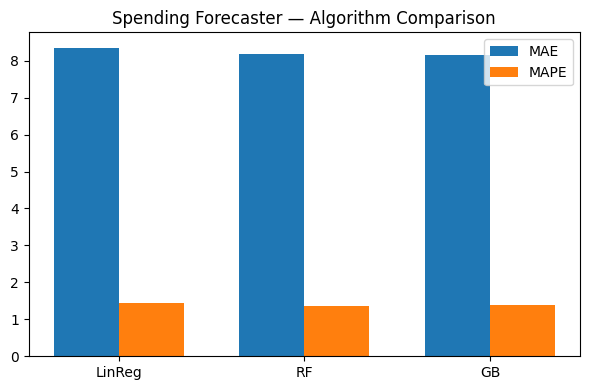

In [10]:
# Assume we have columns: date, category, amount
sp["date"] = pd.to_datetime(sp["date"], errors="coerce")
sp = sp.dropna(subset=["date"]).copy()
sp["month"] = sp["date"].dt.month

X = sp[["category", "month"]]
y = sp["amount"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess_sp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["category"]),
        ("num", StandardScaler(), ["month"]),
    ]
)

sp_models = {
    "LinReg": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GB": GradientBoostingRegressor(random_state=42),
}

sp_results = {}
for name, reg in sp_models.items():
    pipe = Pipeline(steps=[("prep", preprocess_sp), ("reg", reg)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / y_test.replace(0, np.nan)))
    sp_results[name] = {"mae": mae, "mape": mape}
    print(name, "MAE=", mae, "MAPE=", mape)

plt.figure(figsize=(6, 4))
labels = list(sp_results.keys())
mae_vals = [sp_results[k]["mae"] for k in labels]
mape_vals = [sp_results[k]["mape"] for k in labels]
x = np.arange(len(labels))
w = 0.35
plt.bar(x - w/2, mae_vals, width=w, label="MAE")
plt.bar(x + w/2, mape_vals, width=w, label="MAPE")
plt.xticks(x, labels)
plt.title("Spending Forecaster — Algorithm Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Save best spending forecaster model (Gradient Boosting Regressor)

best_sp_model = Pipeline(steps=[("prep", preprocess_sp), ("reg", sp_models["GB"])])
best_sp_model.fit(X, y)
model_path = MODELS_DIR / "spending_forecaster_gb.joblib"
joblib.dump(best_sp_model, model_path)
print("Saved spending forecaster GB model to:", model_path)

## 3. Budget Allocator — algorithm comparison

Goal: predict **budget share per category**.

We will compare multi-output regressors (treated as separate targets):

- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor


In [14]:
ba_path = NOTEBOOK_DIR / "budget_allocator_clean.csv"
if not ba_path.exists():
    raise FileNotFoundError(f"Missing {ba_path}. Run the budget_allocator notebook first.")

ba = pd.read_csv(ba_path).fillna(0)
print(ba.shape)
ba.head()


(22000, 12)


,Rent,Transport,Food,Utilities,Entertainment,Savings,Debt Payments,Insurance,Eating_Out,Health,Education,Miscellaneous
0,0.349436,0.057842,0.325123,0.131416,0.065946,0.070237,0.0,0.0,0.0,0.0,0.0,0.0
1,0.276806,0.066450,0.362444,0.140096,0.057703,0.096501,0.0,0.0,0.0,0.0,0.0,0.0
2,0.241396,0.053836,0.440954,0.158352,0.022103,0.083360,0.0,0.0,0.0,0.0,0.0,0.0
3,0.150576,0.056082,0.504866,0.140077,0.055442,0.092958,0.0,0.0,0.0,0.0,0.0,0.0
4,0.246140,0.016108,0.436368,0.096645,0.085996,0.118743,0.0,0.0,0.0,0.0,0.0,0.0


LinReg RMSE= 4.136132188208719e-17


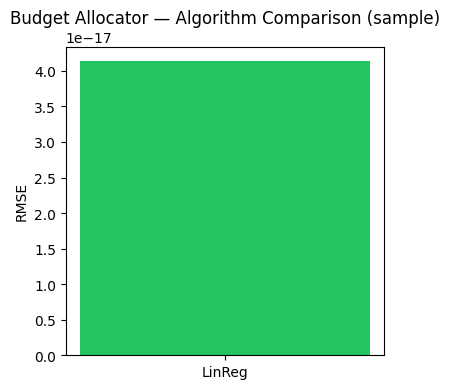

In [16]:
# Here each column is a share; use simple train/test and MSE per row.
# Use only a sample to keep it fast.
ba_sample = ba.sample(n=min(5000, len(ba)), random_state=42)

X = ba_sample.copy()
y = ba_sample.copy()  # predict same structure (auto-encoder style baseline)

from sklearn.multioutput import MultiOutputRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ba_models = {
    "LinReg": LinearRegression(),
    # Uncomment these if you want to try them later (will be slower):
    # "RF": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    # "GB": GradientBoostingRegressor(random_state=42),
}

ba_results = {}
for name, base_reg in ba_models.items():
    reg = MultiOutputRegressor(base_reg)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    mse = mean_squared_error(y_test.values, preds)
    rmse = np.sqrt(mse)
    ba_results[name] = {"rmse": rmse}
    print(name, "RMSE=", rmse)

plt.figure(figsize=(4, 4))
labels = list(ba_results.keys())
rmse_vals = [ba_results[k]["rmse"] for k in labels]
plt.bar(labels, rmse_vals, color=["#22c55e"])
plt.ylabel("RMSE")
plt.title("Budget Allocator — Algorithm Comparison (sample)")
plt.tight_layout()
plt.show()

In [ ]:
# Save best budget allocator model (Multi-output Linear Regression)

best_ba_model = MultiOutputRegressor(LinearRegression())
best_ba_model.fit(X, y)
model_path = MODELS_DIR / "budget_allocator_linreg.joblib"
joblib.dump(best_ba_model, model_path)
print("Saved budget allocator Linear Regression model to:", model_path)

## 4. Goal Predictor — algorithm comparison

Goal: predict **desired savings percentage or rate** from income and other features.

We will compare:

- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor


In [18]:
gp_path = NOTEBOOK_DIR / "goal_predictor_clean.csv"
if not gp_path.exists():
    raise FileNotFoundError(f"Missing {gp_path}. Run the goal_predictor notebook first.")

gp = pd.read_csv(gp_path)
print(gp.shape)
gp.head()


(20000, 2)


,Income,Desired_Savings_Percentage
0,44637.249636,13.890948
1,26858.596592,7.160376
2,50367.605084,13.997808
3,101455.600247,16.455440
4,24875.283548,7.533982


LinReg MAE= 0.017831490962906135 Brier/MSE= 0.0006800652215616665
RF MAE= 0.015595270249160268 Brier/MSE= 0.0003784435645036972
GB MAE= 0.013279279843159958 Brier/MSE= 0.0002469167645193065


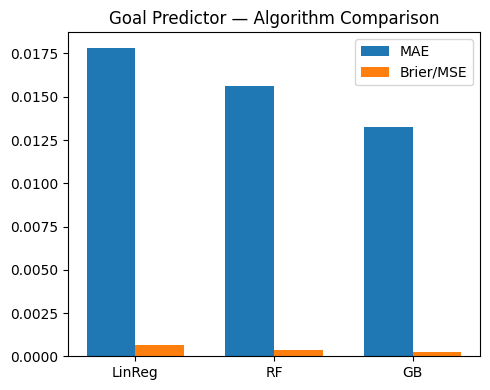

In [19]:
gp["Income"] = pd.to_numeric(gp["Income"], errors="coerce")
gp["Desired_Savings_Percentage"] = pd.to_numeric(gp["Desired_Savings_Percentage"], errors="coerce")
gp = gp.dropna(subset=["Income", "Desired_Savings_Percentage"]).copy()

X = gp[["Income"]]
y = gp["Desired_Savings_Percentage"] / 100.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gp_models = {
    "LinReg": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GB": GradientBoostingRegressor(random_state=42),
}

gp_results = {}
for name, reg in gp_models.items():
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    gp_results[name] = {"mae": mae, "brier": mse}
    print(name, "MAE=", mae, "Brier/MSE=", mse)

plt.figure(figsize=(5, 4))
labels = list(gp_results.keys())
mae_vals = [gp_results[k]["mae"] for k in labels]
brier_vals = [gp_results[k]["brier"] for k in labels]
x = np.arange(len(labels))
w = 0.35
plt.bar(x - w/2, mae_vals, width=w, label="MAE")
plt.bar(x + w/2, brier_vals, width=w, label="Brier/MSE")
plt.xticks(x, labels)
plt.title("Goal Predictor — Algorithm Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Save best goal predictor model (Gradient Boosting Regressor)

best_gp_model = GradientBoostingRegressor(random_state=42)
best_gp_model.fit(X, y)
model_path = MODELS_DIR / "goal_predictor_gb.joblib"
joblib.dump(best_gp_model, model_path)
print("Saved goal predictor GB model to:", model_path)

## 5. Anomaly Detector — algorithm comparison

Goal: flag **unusual transactions**.

We will compare unsupervised methods (no ground-truth anomalies):

- Isolation Forest (primary choice)
- A simple robust z-score baseline on log-amount


In [20]:
an_path = NOTEBOOK_DIR / "anomaly_detector_clean.csv"
if not an_path.exists():
    raise FileNotFoundError(f"Missing {an_path}. Run the anomaly_detector notebook first.")

an = pd.read_csv(an_path)
print(an.shape)
an.head()


(2237, 5)


,date,description,amount,category,type
0,2018-01-10,Phone Company,89.46,Communication,debit
1,2018-01-25,Internet Service Provider,69.99,Communication,debit
2,2018-02-12,Phone Company,89.52,Communication,debit
3,2018-02-26,Internet Service Provider,74.99,Communication,debit
4,2018-03-12,Phone Company,89.52,Communication,debit


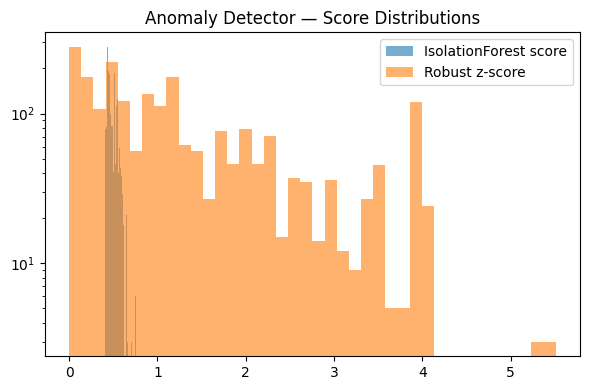

IsolationForest score range: 0.40350183461867933 -> 0.7576748004353407
Robust z-score range: 0.0 -> 5.509091074368007


In [24]:
an["amount"] = an["amount"].astype(float).abs()
X = pd.DataFrame({"log_amount": np.log1p(an["amount"])})

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X)
# score_samples: higher = more normal, so negate to make "more anomalous" higher
iso_scores = -iso.score_samples(X)

# Robust z-score baseline
median = X["log_amount"].median()
mad = (X["log_amount"] - median).abs().median() or 1e-6
z_scores = (X["log_amount"] - median).abs() / mad

plt.figure(figsize=(6, 4))
plt.hist(iso_scores, bins=40, alpha=0.6, label="IsolationForest score")
plt.hist(z_scores, bins=40, alpha=0.6, label="Robust z-score")
plt.yscale("log")
plt.title("Anomaly Detector — Score Distributions")
plt.legend()
plt.tight_layout()
plt.show()

print("IsolationForest score range:", iso_scores.min(), "->", iso_scores.max())
print("Robust z-score range:", z_scores.min(), "->", z_scores.max())


In [ ]:
# Save best anomaly detector model (Isolation Forest)

best_an_model = IsolationForest(contamination=0.05, random_state=42)
best_an_model.fit(X)
model_path = MODELS_DIR / "anomaly_detector_iforest.joblib"
joblib.dump(best_an_model, model_path)
print("Saved anomaly detector IsolationForest model to:", model_path)